In [1]:
import json
# from transformers import AutoTokenizer
import numpy as np
import argparse
import matplotlib.pyplot as plt

In [2]:
# setup bench and model
bench_name = 'mt_bench'
method = 'ea3'
# [L31-8B, V13B]
model_tag = 'L31-8B'
temperature = 0.0

# SD settings
total_token = 60
depth = 6
topk = 10

prefix = 'eagle/evaluation/'
root_dir = ''
prefix = 'eagle/evaluation/'
question_range = None

depth_size_combs = [(d, d*10) for d in range(3, 11)]

In [3]:
def analyze_ans(jsonl_file_path):

    # jsonl_file_base = "llama-2-chat-70b-fp16-base-in-temperature-0.0.jsonl"
    data = []
    with open(jsonl_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_obj = json.loads(line)
            data.append(json_obj)

    # test accept length per round
    # for one choice: total rounds + total new_tokens

    test_choices_cnt = 1  # default 1 test choice (random seed)
    turns_cnt = 0
    new_tokens_cnt = 0
    if question_range is not None:
        data = data[question_range[0]:question_range[1]]

    for datapoint in data:
        records = datapoint['choices'][0]
        idxs = records['idxs']
        new_tokens = records['new_tokens']
        idxs_sum = sum(idxs)
        new_tokens_sum = sum(new_tokens)
        # print(f'{new_tokens_sum} new tokens in {idxs_sum} turns')
        turns_cnt += idxs_sum
        new_tokens_cnt += new_tokens_sum

    print(f'=========Summary for {jsonl_file_path}')
    print(f'{new_tokens_cnt} new tokens in {turns_cnt} turns')
    print(f'Average accept length: {new_tokens_cnt/turns_cnt}')

    avg_accept_length = new_tokens_cnt/turns_cnt
    return avg_accept_length

=========Summary for eagle/evaluation/mt_bench/L31-8B-ea3-t0-tree30-d3-topk10.jsonl
53851 new tokens in 12219 turns
Average accept length: 4.407152794827727
=========Summary for eagle/evaluation/mt_bench/L31-8B-ea3-t0-tree40-d4-topk10.jsonl
53582 new tokens in 10668 turns
Average accept length: 5.022684664416948
=========Summary for eagle/evaluation/mt_bench/L31-8B-ea3-t0-tree50-d5-topk10.jsonl
53809 new tokens in 9681 turns
Average accept length: 5.55820679681851
=========Summary for eagle/evaluation/mt_bench/L31-8B-ea3-t0-tree60-d6-topk10.jsonl
54338 new tokens in 9023 turns
Average accept length: 6.022165576859138
=========Summary for eagle/evaluation/mt_bench/L31-8B-ea3-t0-tree70-d7-topk10.jsonl
53597 new tokens in 8368 turns
Average accept length: 6.4049952198852775
=========Summary for eagle/evaluation/mt_bench/L31-8B-ea3-t0-tree80-d8-topk10.jsonl
53265 new tokens in 7997 turns
Average accept length: 6.660622733525072
=========Summary for eagle/evaluation/mt_bench/L31-8B-ea3-t0-t

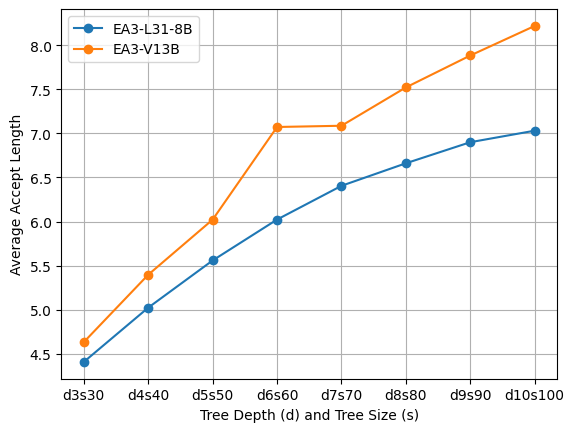

In [4]:
depth_size = [(d, d*10) for d in range(3, 11)]

# analyze and draw
def get_analysis(model_tag):
    xs = []
    ys = []

    for depth, total_token in depth_size:
        jsonl_file = f'{bench_name}/{model_tag}-{method}-t{int(temperature)}-tree{total_token}-d{depth}-topk{topk}.jsonl'
        jsonl_file = f'{root_dir}{prefix}{jsonl_file}'

        avg_acc = analyze_ans(jsonl_file)
        ys.append(avg_acc)
        label = f'd{depth}s{total_token}'
        xs.append(label)
    
    return xs, ys

plt.figure()
plt.grid()
plt.xlabel('Tree Depth (d) and Tree Size (s)')
plt.ylabel('Average Accept Length')
plt.plot(*get_analysis('L31-8B'), marker='o', label='EA3-L31-8B')
plt.plot(*get_analysis('V13B'), marker='o', label='EA3-V13B')
plt.legend()
plt.show()